In [32]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error,mean_squared_error,r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [3]:
store_sales=pd.read_csv("train.csv")

In [4]:
store_sales.head()

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10


check for null val

In [5]:
store_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   date    913000 non-null  object
 1   store   913000 non-null  int64 
 2   item    913000 non-null  int64 
 3   sales   913000 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 27.9+ MB


troping store and id columns

In [6]:
store_sales=store_sales.drop(['store','item'],axis=1)
store_sales.head()

,date,sales
0,2013-01-01,13
1,2013-01-02,11
2,2013-01-03,14
3,2013-01-04,13
4,2013-01-05,10


In [7]:
store_sales['date']=pd.to_datetime(store_sales['date'])

In [8]:
store_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   date    913000 non-null  datetime64[ns]
 1   sales   913000 non-null  int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 13.9 MB


In [9]:
store_sales['date'] = store_sales['date'].astype('period[M]')

In [10]:
monthly_sales=store_sales.groupby('date').sum().reset_index()

In [11]:
monthly_sales['date']=monthly_sales['date'].dt.to_timestamp()

In [12]:
monthly_sales.head()

,date,sales
0,2013-01-01,454904
1,2013-02-01,459417
2,2013-03-01,617382
3,2013-04-01,682274
4,2013-05-01,763242


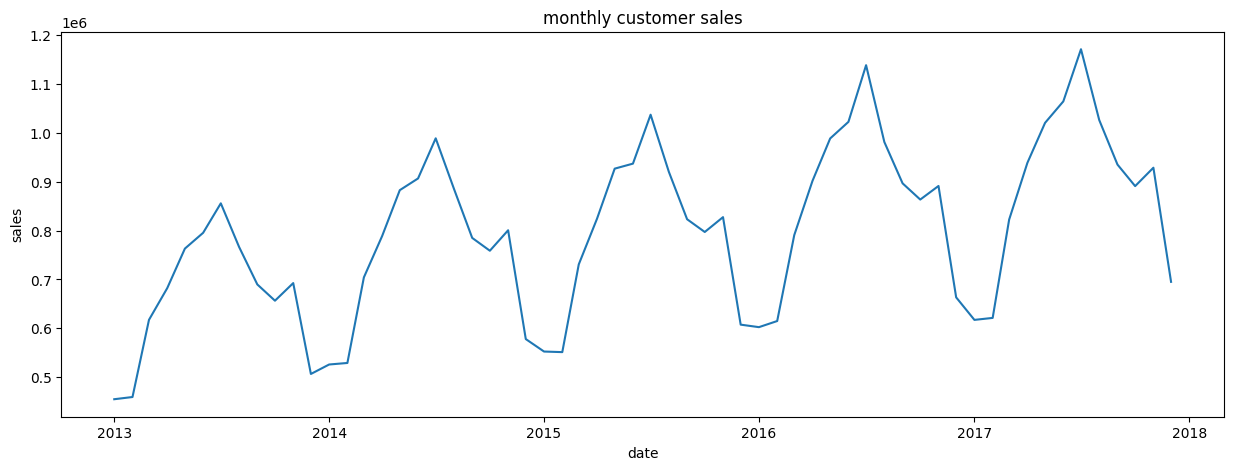

In [13]:
plt.figure(figsize=(15,5))
plt.plot(monthly_sales['date'],monthly_sales['sales'])
plt.xlabel('date')
plt.ylabel('sales')
plt.title('monthly customer sales')
plt.show()

In [14]:
monthly_sales['sales_diff']=monthly_sales['sales'].diff()
monthly_sales=monthly_sales.dropna()
monthly_sales.head()

,date,sales,sales_diff
1,2013-02-01,459417,4513.0
2,2013-03-01,617382,157965.0
3,2013-04-01,682274,64892.0
4,2013-05-01,763242,80968.0
5,2013-06-01,795597,32355.0


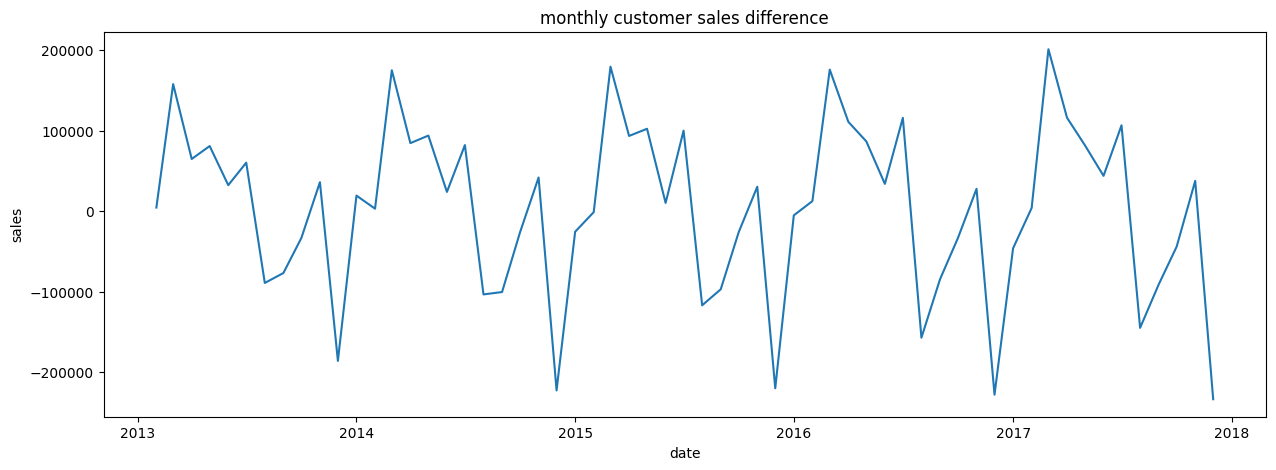

In [15]:
plt.figure(figsize=(15,5))
plt.plot(monthly_sales['date'],monthly_sales['sales_diff'])
plt.xlabel('date')
plt.ylabel('sales')
plt.title('monthly customer sales difference')
plt.show()

In [16]:
supervised_data=monthly_sales.drop(['date','sales'],axis=1)
supervised_data.head()

,sales_diff
1,4513.0
2,157965.0
3,64892.0
4,80968.0
5,32355.0


In [17]:
for i in range(1,13):
    column='month'+str(i)
    supervised_data[column]=supervised_data['sales_diff'].shift(i)
supervised_data=supervised_data.dropna().reset_index(drop=True)
supervised_data.head(500)

,sales_diff,month1,month2,month3,month4,month5,month6,month7,month8,month9,month10,month11,month12
0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0,80968.0,64892.0,157965.0,4513.0
1,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0,80968.0,64892.0,157965.0
2,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0,80968.0,64892.0
3,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0,80968.0
4,23965.0,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0
5,82168.0,23965.0,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0
6,-103414.0,82168.0,23965.0,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0
7,-100472.0,-103414.0,82168.0,23965.0,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0
8,-26241.0,-100472.0,-103414.0,82168.0,23965.0,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0
9,41900.0,-26241.0,-100472.0,-103414.0,82168.0,23965.0,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0


In [18]:
train_data=supervised_data[:-12]
test_data=supervised_data[-12:]
print(train_data.shape,test_data.shape)

(35, 13) (12, 13)


In [19]:
scaler=MinMaxScaler(feature_range=(-1,1))
scaler.fit(train_data)
train_data=scaler.transform(train_data)
test_data=scaler.transform(test_data)

In [20]:
x_train,y_train=train_data[:,1:],train_data[:,0:1]
x_test,y_test=test_data[:,1:],test_data[:,0:1]

In [21]:
y_train=y_train.ravel()
y_test=y_test.ravel()
print(y_train.shape)
print(y_test.shape)
print(x_train.shape)
print(x_test.shape)


(35,)
(12,)
(35, 12)
(12, 12)


In [22]:
sales_dates=monthly_sales['date'][-12:].reset_index(drop=True)
predict_df=pd.DataFrame(sales_dates)

In [23]:
act_sales=monthly_sales['sales'][-13:].to_list()
print(act_sales)

[663411, 617306, 621369, 822667, 938862, 1020686, 1064624, 1171393, 1026403, 935263, 891160, 928837, 695170]


In [28]:
lr_model=LinearRegression()
lr_model.fit(x_train,y_train)
lr_pre=lr_model.predict(x_test)

In [33]:
lr_pre=lr_pre.reshape(-1,1)
lr_pre_test_set=np.concatenate([lr_pre,x_test],axis=1)
lr_pre_test_set=scaler.inverse_transform(lr_pre_test_set)

In [34]:
result_list=[]
for index in range(0,len(lr_pre_test_set)):
    result_list.append(lr_pre_test_set[index][0]+act_sales[index])
lr_pre_series=pd.Series(result_list, name='Linear prediction')
predict_df=predict_df.merge(lr_pre_series,left_index=True,right_index=True)

In [35]:
predict_df.head()

,date,Linear prediction
0,2017-01-01,6.479148e+05
1,2017-02-01,6.283374e+05
2,2017-03-01,8.195190e+05
3,2017-04-01,9.436391e+05
4,2017-05-01,1.033653e+06


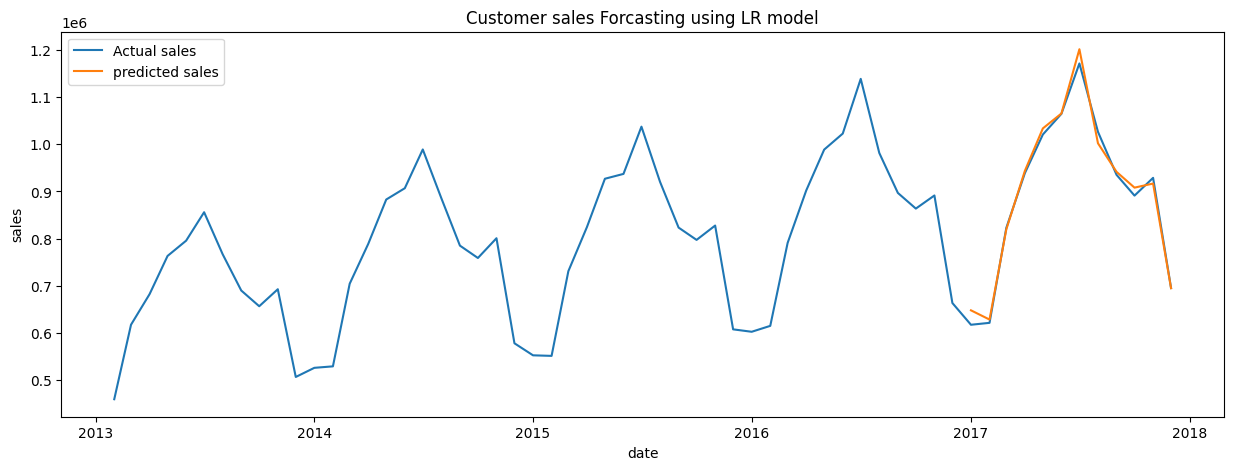

In [37]:
plt.figure(figsize=(15,5))
plt.plot(monthly_sales['date'],monthly_sales['sales'])
plt.plot(predict_df['date'],predict_df['Linear prediction'])
plt.xlabel('date')
plt.ylabel('sales')
plt.title('Customer sales Forcasting using LR model')
plt.legend(['Actual sales','predicted sales'])
plt.show()